# Step 1: Per-Dataset Analysis

In [1]:
# pip install numpy pandas scipy statsmodels scikit-posthocs matplotlib seaborn

In [2]:
# binary, multiclass, multilabel_native, multilabel_powerset, all
scenario = "binary"
# significance level (used globally)
alpha = 0.05 

In [3]:
# Parameters
scenario = "multilabel_native"
alpha = 0.05


In [4]:
# change ~/anaconda3/Lib/site-packages/matplotlib/_mathtext.py:659
# to uniindex = 0x2D  # currency char, for lack of anything better
from matplotlib import font_manager
import matplotlib.pyplot as plt

font_files = font_manager.findSystemFonts(fontpaths=['fonts'])
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    prop = font_manager.FontProperties(fname=font_file)
    print(font_file, prop.get_name())

plt.rcParams['font.family'] = ['CMU Serif', 'DejaVu Sans']
plt.rcParams['text.usetex'] = False
plt.rcParams['axes.unicode_minus'] = False

C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunti.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunrm.ttf CMU Serif
C:\Users\marce\git\auto-ml-evaluation-2025\fonts\cmunbx.ttf CMU Serif


In [5]:
from IPython.display import display
from scipy.stats import shapiro, levene, f_oneway, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import numpy as np
import os
import pandas as pd
import scikit_posthocs as sp
import seaborn as sns

In [6]:
def arcsine_sqrt_transform(x, eps=1e-6):
    """
    Applies arcsine sqrt transform for data in [0,1].
    Handles corner cases by clamping [0,1] to [eps, 1-eps].
    """
    x_clamped = np.clip(x, eps, 1.0 - eps)
    return np.arcsin(np.sqrt(x_clamped))

In [7]:
def log1p_transform(x, eps=1e-6):
    """
    Safely applies log(1 + x). 
    If any x < 0, add a small shift so that all data >= -0.9999... 
    (In typical training-time data, negative times shouldn't occur. 
     But in case of small floating errors, handle it.)
    """
    min_val = x.min()
    shift = 0.0
    if min_val < 0:
        shift = abs(min_val) + eps  # ensure positivity
    return np.log1p(x + shift)

In [8]:
def check_normality_auto(data, threshold=50):
    """
    Automatically choose between Shapiro–Wilk (SW) and Kolmogorov–Smirnov (K–S)
    based on sample size.
    
    :param data: 1D array-like of numeric values
    :param threshold: sample-size threshold for deciding which test to use
    :return: dict with keys: 
        'test_name', 'statistic', 'p_value', 'is_normal'
    """
    data = pd.Series(data).dropna()  # ensure it's a clean Series
    n = len(data)
    
    # If not enough points or no data
    if n < 3:
        return {
            'test_name': 'none',
            'statistic': np.nan,
            'p_value': np.nan,
            'is_normal': False,
            'reason': f"Not enough data points (n={n})"
        }
    
    if n <= threshold:
        # Use Shapiro–Wilk
        stat, p_val = shapiro(data)
        test_name = 'Shapiro-Wilk'
    else:
        # Use Kolmogorov–Smirnov
        # We compute the mean and std of the data to define the normal distribution
        mu, sigma = data.mean(), data.std(ddof=1)
        if sigma == 0:
            # If all data are identical, that might cause zero std
            # K-S is not well-defined here, or it trivially fails
            return {
                'test_name': 'Kolmogorov-Smirnov',
                'statistic': 0.0,
                'p_value': 1.0,
                'is_normal': True,
                'reason': 'All data points identical'
            }
        # kstest with cdf='norm' requires specifying loc=mu, scale=sigma
        stat, p_val = kstest(data, 'norm', args=(mu, sigma))
        test_name = 'Kolmogorov-Smirnov'
    
    is_normal = (p_val > alpha)
    return {
        'test_name': test_name,
        'statistic': stat,
        'p_value': p_val,
        'is_normal': is_normal
    }

In [9]:
def check_normality_variances(df, metric_col='f1', group_col='framework'):
    """
    1) Checks normality for each framework (automatically deciding between
       Shapiro-Wilk or Kolmogorov-Smirnov) and collects results in norm_results.
    2) Determines 'normal' = True if *all* frameworks pass the normality test at alpha.
    3) Checks homogeneity of variances via Levene’s test across all frameworks.
    
    Returns:
      norm_results: dict mapping framework -> { 'test_name', 'statistic', 'p_value', 'is_normal', ... }
      normal: bool indicating if all frameworks are normal
      homoscedastic: bool indicating if Levene’s test fails to reject equal variances
    """
    frameworks = df[group_col].unique()
    
    # Dictionary to store normality results per framework
    norm_results = {}
    
    # 1) Check normality for each group (framework)
    pvals_normality = []
    for fw in frameworks:
        data_fw = df.loc[df[group_col] == fw, metric_col].dropna()
        # Decide between Shapiro-Wilk or Kolmogorov-Smirnov tests automatically
        norm_res = check_normality_auto(data_fw, threshold=50)
        norm_results[fw] = norm_res
        # Check if the normality test was actually performed
        if norm_res['test_name'] != 'none':
            # We'll store the p-value to see if each group individually passes normality
            pvals_normality.append(norm_res['p_value'])
    
    # "Normal" if all frameworks pass the normality test (is_normal == True)
    # We only consider frameworks that had enough data for a test.
    # If pvals_normality is empty (no frameworks or all had <3 data), normal=False
    if len(pvals_normality) == 0:
        normal = False
    else:
        normal = all(p > alpha for p in pvals_normality)
    
    # 2) Check homogeneity of variances using Levene’s test
    group_data = [df.loc[df[group_col] == fw, metric_col].dropna() for fw in frameworks]
    if sum(len(g) > 0 for g in group_data) < 2:
        homoscedastic = False
    else:
        stat, pval = levene(*[g for g in group_data if len(g) > 1])
        homoscedastic = (pval > alpha)
    
    return norm_results, normal, homoscedastic

In [10]:
def do_parametric_anova(df, metric_col='f1', group_col='framework'):
    """
    Performs one-way ANOVA + Tukey post-hoc if significant.
    Ensures all frameworks appear in the pairwise matrix, even if they have no valid trials.
    """
    results = {}
    frameworks = sorted(df[group_col].unique())  # Ensure consistent ordering
    data_groups = [df.loc[df[group_col] == fw, metric_col].dropna() for fw in frameworks]

    # Check for empty groups or all identical values
    if any(len(g) < 2 for g in data_groups) or all(np.var(g) == 0 for g in data_groups if len(g) > 1):
        results['anova_F'] = np.nan
        results['anova_p'] = np.nan
        tukey_matrix = pd.DataFrame(np.nan, index=frameworks, columns=frameworks)
        results['posthoc'] = tukey_matrix
        return results

    # ANOVA Test
    f_stat, p_val = f_oneway(*data_groups)
    results['anova_F'] = f_stat
    results['anova_p'] = p_val

    # Prepare an empty symmetrical matrix with NaNs
    tukey_matrix = pd.DataFrame(np.nan, index=frameworks, columns=frameworks)

    if p_val < alpha:
        # Tukey Post-Hoc Test
        metric_values = []
        group_labels = []
        for fw, g_data in zip(frameworks, data_groups):
            metric_values.extend(g_data)
            group_labels.extend([fw] * len(g_data))

        tukey = pairwise_tukeyhsd(endog=metric_values, groups=group_labels, alpha=alpha)

        # Fill Tukey results into the matrix
        for i, j, p_val in zip(tukey._multicomp.pairindices[0], tukey._multicomp.pairindices[1], tukey.pvalues):
            fw1, fw2 = tukey.groupsunique[i], tukey.groupsunique[j]
            tukey_matrix.loc[fw1, fw2] = p_val
            tukey_matrix.loc[fw2, fw1] = p_val  # Mirror the matrix

    results['posthoc'] = tukey_matrix  # Store the complete matrix

    return results

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import scikit_posthocs as sp

def do_nonparametric_kruskal(df, all_frameworks, metric_col='f1', group_col='framework'):
    """
    Performs Kruskal-Wallis + Dunn post-hoc if significant.
    Ensures all frameworks appear in the pairwise matrix, even if they have no valid trials.
    
    Parameters:
        - df: DataFrame with results
        - metric_col: Metric being analyzed
        - group_col: Framework column name
        - alpha: Significance level
        - all_frameworks: List of all possible frameworks (even if missing in df)
    
    Returns:
        - Dictionary with Kruskal-Wallis test results and posthoc Dunn matrix.
    """
    results = {}

    # Ensure ALL frameworks are considered (even those missing from df)
    if all_frameworks is None:
        all_frameworks = sorted(df[group_col].unique())  # Default: existing frameworks only
    else:
        all_frameworks = sorted(all_frameworks)  # Use full list of expected frameworks

    # Extract valid data groups (ignore completely missing frameworks for now)
    valid_groups = {fw: df.loc[df[group_col] == fw, metric_col].dropna().values for fw in all_frameworks}
    
    # Filter out empty lists (frameworks that never produced results)
    valid_groups = {fw: data for fw, data in valid_groups.items() if len(data) > 0}
    
    # Check if we have at least two valid frameworks for Kruskal-Wallis
    if len(valid_groups) < 2:
        results['kruskal_H'] = np.nan
        results['kruskal_p'] = np.nan
        dunn_matrix = pd.DataFrame(np.nan, index=all_frameworks, columns=all_frameworks)
        results['posthoc'] = dunn_matrix
        return results

    # Run Kruskal-Wallis on valid groups only
    try:
        h_stat, p_val = kruskal(*valid_groups.values(), nan_policy='omit')
    except ValueError:  # Handles cases where Kruskal cannot be computed
        h_stat, p_val = np.nan, np.nan

    results['kruskal_H'] = h_stat
    results['kruskal_p'] = p_val

    # Prepare an empty symmetrical matrix with NaNs (ensures all frameworks appear)
    dunn_matrix = pd.DataFrame(np.nan, index=all_frameworks, columns=all_frameworks)

    if p_val < alpha:
        # Dunn Post-Hoc Test (only if we had valid groups)
        df_ph = df[[group_col, metric_col]].dropna()
        if not df_ph.empty:
            dunn_res = sp.posthoc_dunn(df_ph, val_col=metric_col, group_col=group_col, p_adjust='holm')

            # Ensure ALL frameworks are in the matrix (even if missing from Dunn’s results)
            for fw1 in all_frameworks:
                for fw2 in all_frameworks:
                    if fw1 in dunn_res.index and fw2 in dunn_res.columns:
                        dunn_matrix.loc[fw1, fw2] = dunn_res.loc[fw1, fw2]

    results['posthoc'] = dunn_matrix  # Store the complete matrix

    return results


In [12]:
def decide_transform_and_analyze(df, all_frameworks, metric_col, group_col='framework'):
    """
    1) Decide transform:
       - If metric_col == 'f1', do arcsine sqrt transform
       - If metric_col == 'training_time', do log1p transform
       - Otherwise, no transform.
    2) Check normality & homoscedasticity on transformed data
    3) If normal & homoscedastic:
         -> ANOVA + Tukey on transformed data
       Else:
         -> Kruskal-Wallis + Dunn on original data
    """
    result = {}
    
    # Drop rows with missing values for this metric
    df = df.dropna(subset=[metric_col]).copy()
    
    # If fewer than 2 frameworks have valid data, skip
    unique_fw = df[group_col].unique()
    if len(unique_fw) < 2:
        result['warning'] = 'Fewer than 2 frameworks have data; skipping test.'
        return result
    
    # Decide which transform to apply
    if metric_col == 'f1':
        # arcsine sqrt transform (common for [0,1] data)
        df['transformed_val'] = arcsine_sqrt_transform(df[metric_col].values)
        chosen_transform = 'arcsine_sqrt'
    elif metric_col == 'training_time':
        # log1p transform (common for skewed positive data)
        df['transformed_val'] = log1p_transform(df[metric_col].values)
        chosen_transform = 'log1p'
    else:
        # default: no transform
        df['transformed_val'] = df[metric_col]
        chosen_transform = 'none'
    
    result['chosen_transform'] = chosen_transform
    
    # ----------------------------------------------------
    # 1) Check parametric assumptions on the transformed data
    #    We'll create a mini DataFrame with just {group_col, 'transformed_val'}
    #    and pass 'transformed_val' as 'metric_col' to the checking function
    # ----------------------------------------------------
    df_for_assumptions = df[[group_col, 'transformed_val']].copy()
    
    norm_results, normal, homoscedastic = check_normality_variances(
        df_for_assumptions,
        metric_col='transformed_val',
        group_col=group_col
    )

    result['normal_tests'] = set([v['test_name'] for v in norm_results.values()])
    result['assumptions'] = {'normal': normal, 'homoscedastic': homoscedastic}
    
    # ----------------------------------------------------
    # 2) Decide which statistical test to run
    # ----------------------------------------------------
    if normal and homoscedastic:
        # Use parametric: One-Way ANOVA + Tukey
        result['method'] = 'ANOVA + Tukey'
        
        # We'll do ANOVA on the transformed values
        # Make a small DataFrame with the same format as do_parametric_anova expects:
        # it looks for a column matching 'metric_col' for the data.
        anova_df = df_for_assumptions.rename(columns={'transformed_val': 'temp_metric'})
        
        # Now run ANOVA with metric_col='temp_metric'
        out = do_parametric_anova(
            anova_df,
            metric_col='temp_metric',
            group_col=group_col
        )
        result.update(out)
        
    else:
        # Use non-parametric: Kruskal-Wallis + Dunn
        # Typically, we run it on the ORIGINAL metric (not transformed)
        result['method'] = 'Kruskal-Wallis + Dunn'
        
        # Build a mini DataFrame with just {group_col, <original metric>}
        kruskal_df = df[[group_col, metric_col]].copy()

        out = do_nonparametric_kruskal(
            kruskal_df,
            all_frameworks=all_frameworks,
            metric_col=metric_col,
            group_col=group_col
        )
        result.update(out)
    
    return result

In [13]:
def analyze_per_dataset(df):
    """
    Loops through each dataset, does a separate analysis for 'f1' and 'training_time'.
    Applies appropriate transform automatically for parametric test attempts.
    Returns a list of results, one per dataset.
    """
    all_results = []
    datasets = df['dataset'].unique()
    all_frameworks = df['framework'].unique().tolist()
    
    for dset in datasets:
        dsub = df[df['dataset'] == dset]
        
        # Analyze F1
        f1_res = decide_transform_and_analyze(dsub, all_frameworks, metric_col='f1')
        
        # Analyze training_time
        time_res = decide_transform_and_analyze(dsub, all_frameworks, metric_col='training_time')
        
        row = {
            'dataset': dset,
            'f1_analysis': f1_res,
            'time_analysis': time_res
        }
        all_results.append(row)
    
    return all_results

In [14]:
def print_formatted_result(k, v):
    if k == 'posthoc':
        print('  posthoc:')
        display(v)
    else:
        print(f"  {k}: {v}")

In [15]:
# ========================
# ====== MAIN CALL =======
# ========================

# Example CSV structure: dataset, framework, trial, f1, training_time
# e.g., "31,autogluon,1,0.6949,8.6927"
df = pd.read_csv(f"stats/{scenario}/experimental_results.csv")
df = df.rename(columns={
    'Dataset': 'dataset', 
    'Dataset Type': 'type', 
    'Framework': 'framework', 
    'Trial': 'trial', 
    'F1 Score': 'f1', 
    'Training Time': 'training_time'}
)

# Run the analysis
results = analyze_per_dataset(df)

# Assert statistical significance
# assert len(results) == df['dataset'].nunique(), 'Some datasets are missing in the results'
# assert all(isinstance(r['f1_analysis']['posthoc'], pd.DataFrame) for r in results), "Not all posthoc F1 Score results are DataFrames"
# assert all(isinstance(r['time_analysis']['posthoc'], pd.DataFrame) for r in results), "Not all posthoc Training Time results are DataFrames"

# Print some sample outputs
for r in results:
    print(f"\n===== Dataset {r['dataset']} =====")
    print("F1 Analysis:")
    for k, v in r['f1_analysis'].items():
        print_formatted_result(k, v)
    print("\nTime Analysis:")
    for k, v in r['time_analysis'].items():
        print_formatted_result(k, v)


===== Dataset 285 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 43.431994047619014
  kruskal_p: 1.9924259951501485e-09
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,1.000000e+00,8.283041e-08,0.066976
autokeras,1.000000e+00,1.000000e+00,2.497084e-07,0.068228
autosklearn,8.283041e-08,2.497084e-07,1.000000e+00,1.000000
fedot,6.697636e-02,6.822766e-02,1.000000e+00,1.000000



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 55.048015873015856
  kruskal_p: 6.70611461914932e-12
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000,1.679719e-03,9.528927e-04,0.088456
autokeras,0.001680,1.000000e+00,6.248156e-12,0.000803
autosklearn,0.000953,6.248156e-12,1.000000e+00,0.892527
fedot,0.088456,8.026368e-04,8.925271e-01,1.000000



===== Dataset 41464 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': True, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 52.459016393442624
  kruskal_p: 4.061339800128413e-12
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,0.000586,1.317964e-12,NaN
autokeras,5.859585e-04,1.000000,5.859585e-04,NaN
autosklearn,1.317964e-12,0.000586,1.000000e+00,NaN
fedot,NaN,NaN,NaN,NaN



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 46.333114754098375
  kruskal_p: 8.687442966701108e-11
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000,7.902125e-05,8.201892e-03,NaN
autokeras,0.000079,1.000000e+00,4.315705e-11,NaN
autosklearn,0.008202,4.315705e-11,1.000000e+00,NaN
fedot,NaN,NaN,NaN,NaN



===== Dataset 41465 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': True, 'homoscedastic': True}
  method: ANOVA + Tukey
  anova_F: 945.3866289416914
  anova_p: 4.696135556148512e-60
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,NaN,0.0,0.000000,0.000000
autokeras,0.0,NaN,0.000000,0.000000
autosklearn,0.0,0.0,NaN,0.000431
fedot,0.0,0.0,0.000431,NaN



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 70.2962962962963
  kruskal_p: 3.688169027696872e-15
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000,1.299117e-02,5.245911e-03,1.910774e-06
autokeras,0.012991,1.000000e+00,2.434935e-08,5.229346e-14
autosklearn,0.005246,2.434935e-08,1.000000e+00,5.675945e-02
fedot,0.000002,5.229346e-14,5.675945e-02,1.000000e+00



===== Dataset 41468 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': True, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 68.43174294060373
  kruskal_p: 9.247353982163571e-15
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,3.194427e-07,2.238750e-14,0.019789
autokeras,3.194427e-07,1.000000e+00,2.174473e-02,0.021745
autosklearn,2.238750e-14,2.174473e-02,1.000000e+00,0.000003
fedot,1.978930e-02,2.174473e-02,3.167701e-06,1.000000



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 62.98874824191279
  kruskal_p: 1.350443122030475e-13
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,9.443728e-01,0.000053,4.877696e-10
autokeras,9.443728e-01,1.000000e+00,0.000052,3.725647e-10
autosklearn,5.332221e-05,5.180270e-05,1.000000,4.358288e-02
fedot,4.877696e-10,3.725647e-10,0.043583,1.000000e+00



===== Dataset 41470 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': True, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 67.14833333333337
  kruskal_p: 1.7406497889548168e-14
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,0.000562,1.929158e-15,0.000047
autokeras,5.620906e-04,1.000000,4.722723e-05,0.487668
autosklearn,1.929158e-15,0.000047,1.000000e+00,0.000562
fedot,4.722723e-05,0.487668,5.620906e-04,1.000000



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 72.51185185185187
  kruskal_p: 1.2367047762752941e-15
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,1.280017e-02,5.164573e-07,2.159169e-15
autokeras,1.280017e-02,1.000000e+00,1.377423e-02,5.164573e-07
autosklearn,5.164573e-07,1.377423e-02,1.000000e+00,1.280017e-02
fedot,2.159169e-15,5.164573e-07,1.280017e-02,1.000000e+00



===== Dataset 41471 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': True}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 70.38907407407407
  kruskal_p: 3.523245992504394e-15
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,0.000001,3.197997e-15,0.007389
autokeras,1.005264e-06,1.000000,7.389217e-03,0.029967
autosklearn,3.197997e-15,0.007389,1.000000e+00,0.000002
fedot,7.389217e-03,0.029967,1.542769e-06,1.000000



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 72.3901851851852
  kruskal_p: 1.3131992834014296e-15
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000e+00,1.272618e-02,1.252838e-02,5.167039e-07
autokeras,1.272618e-02,1.000000e+00,1.115886e-07,6.968621e-15
autosklearn,1.252838e-02,1.115886e-07,1.000000e+00,1.571496e-02
fedot,5.167039e-07,6.968621e-15,1.571496e-02,1.000000e+00



===== Dataset 41473 =====
F1 Analysis:
  chosen_transform: arcsine_sqrt
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': True, 'homoscedastic': True}
  method: ANOVA + Tukey
  anova_F: 3446.5784042621262
  anova_p: 3.1277754173899806e-80
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,NaN,0.077498,0.000000e+00,0.000000e+00
autokeras,0.077498,NaN,0.000000e+00,0.000000e+00
autosklearn,0.000000,0.000000,NaN,2.317257e-12
fedot,0.000000,0.000000,2.317257e-12,NaN



Time Analysis:
  chosen_transform: log1p
  normal_tests: {'Shapiro-Wilk'}
  assumptions: {'normal': False, 'homoscedastic': False}
  method: Kruskal-Wallis + Dunn
  kruskal_H: 65.5027265156562
  kruskal_p: 3.915777695154622e-14
  posthoc:


,autogluon,autokeras,autosklearn,fedot
autogluon,1.000000,9.406954e-05,0.777576,2.244555e-04
autokeras,0.000094,1.000000e+00,0.000193,3.704758e-15
autosklearn,0.777576,1.932307e-04,1.000000,1.381105e-04
fedot,0.000224,3.704758e-15,0.000138,1.000000e+00


## Statistical assumptions and test results 

In [16]:
f1_stat_results = pd.DataFrame([
    {
        'dataset': r['dataset'],
        'normal': r['f1_analysis']['assumptions']['normal'],
        'homoscedastic': r['f1_analysis']['assumptions']['homoscedastic'],
        'parametric': r['f1_analysis']['assumptions']['normal'] and r['f1_analysis']['assumptions']['homoscedastic'],
        'method': r['f1_analysis']['method'],
        'p-value': r['f1_analysis']['kruskal_p'] if 'Kruskal' in r['f1_analysis']['method'] else r['f1_analysis']['anova_p'],
        'significant': (r['f1_analysis']['kruskal_p'] < alpha) if 'Kruskal' in r['f1_analysis']['method'] else (r['f1_analysis']['anova_p'] < alpha),
    }
    for r in results
]).set_index('dataset')

f1_stat_results.to_csv(f"stats/{scenario}/step_1_per_dataset_stat_results_f1.csv")
f1_stat_results

,normal,homoscedastic,parametric,method,p-value,significant
dataset,,,,,,
285,False,False,False,Kruskal-Wallis + Dunn,1.992426e-09,True
41464,True,False,False,Kruskal-Wallis + Dunn,4.061340e-12,True
41465,True,True,True,ANOVA + Tukey,4.696136e-60,True
41468,True,False,False,Kruskal-Wallis + Dunn,9.247354e-15,True
41470,True,False,False,Kruskal-Wallis + Dunn,1.740650e-14,True
41471,False,True,False,Kruskal-Wallis + Dunn,3.523246e-15,True
41473,True,True,True,ANOVA + Tukey,3.127775e-80,True


In [17]:
time_stat_results = pd.DataFrame([
    {
        'dataset': r['dataset'],
        'normal': r['time_analysis']['assumptions']['normal'],
        'homoscedastic': r['time_analysis']['assumptions']['homoscedastic'],
        'parametric': r['time_analysis']['assumptions']['normal'] and r['time_analysis']['assumptions']['homoscedastic'],
        'method': r['time_analysis']['method'],
        'p-value': r['time_analysis']['kruskal_p'] if 'Kruskal' in r['time_analysis']['method'] else r['time_analysis']['anova_p'],
        'significant': (r['time_analysis']['kruskal_p'] < alpha) if 'Kruskal' in r['time_analysis']['method'] else (r['time_analysis']['anova_p'] < alpha),
    }
    for r in results
]).set_index('dataset')

time_stat_results.to_csv(f"stats/{scenario}/step_1_per_dataset_stat_results_time.csv")
time_stat_results

,normal,homoscedastic,parametric,method,p-value,significant
dataset,,,,,,
285,False,False,False,Kruskal-Wallis + Dunn,6.706115e-12,True
41464,False,False,False,Kruskal-Wallis + Dunn,8.687443e-11,True
41465,False,False,False,Kruskal-Wallis + Dunn,3.688169e-15,True
41468,False,False,False,Kruskal-Wallis + Dunn,1.350443e-13,True
41470,False,False,False,Kruskal-Wallis + Dunn,1.236705e-15,True
41471,False,False,False,Kruskal-Wallis + Dunn,1.313199e-15,True
41473,False,False,False,Kruskal-Wallis + Dunn,3.915778e-14,True


## Plots

In [18]:
def aggregate_posthocs():
    posthocs_agg = [{
        'dataset': r['dataset'],
        'posthoc_f1': r['f1_analysis']['posthoc'],
        'posthoc_training_time': r['time_analysis']['posthoc']
    } for r in results]
    return posthocs_agg

In [19]:
def create_mean_metric_dict(df, dataset_col='dataset', framework_col='framework', metric_col='f1'):
    """
    Create a nested dictionary: mean_metric_dict[dataset_id][framework_name] = mean(metric).
    
    :param df: A DataFrame with columns for dataset, framework, and metric (e.g., f1).
    :param dataset_col: Name of the column that identifies each dataset.
    :param framework_col: Name of the column that identifies each framework.
    :param metric_col: Name of the metric column (e.g. 'f1').
    :return: A dict of dicts. For example:
             {
                 31: {'autogluon': 0.68, 'autokeras': 0.70, '4intelligence': 0.60},
                 37: {'autogluon': 0.76, 'autokeras': 0.75, '4intelligence': 0.83},
                 ...
             }
    """

    # 1) Group by dataset and framework, compute the mean of the metric
    grouped = df.groupby([dataset_col, framework_col], as_index=False)[metric_col].mean()

    # 2) Build the nested dictionary
    mean_dict = {}
    for _, row in grouped.iterrows():
        ds = row[dataset_col]
        fw = row[framework_col]
        val = row[metric_col]
        
        if ds not in mean_dict:
            mean_dict[ds] = {}
        mean_dict[ds][fw] = val

    return mean_dict

In [20]:
def build_win_loss_matrix(
    posthocs, 
    mean_metric_dict,
    metric_col='f1'
):
    """
    Builds a win–loss count matrix for a given metric (e.g., 'f1' or 'training_time') based on:
      1) posthocs: list of dicts with a key f"posthoc_{metric_col}" containing pairwise significance (p-values).
      2) mean_metric_dict: dictionary with mean metric per (dataset, framework), 
         e.g. mean_metric_dict[ds][fw] = mean F1 or mean training time.
      3) metric_col: string that indicates the metric name (defaults to 'f1').
         - If metric_col == 'f1', higher is better.
         - If metric_col == 'training_time', lower is better.

    Returns a pd.DataFrame (F×F), with index & columns = unique frameworks,
    and cell (i, j) = number of datasets where framework i significantly outperformed framework j.
    """

    # Decide if "higher is better" or "lower is better"
    if metric_col == 'training_time':
        higher_is_better = False
        posthoc_key = 'posthoc_training_time'
    else:
        # default or specifically 'f1'
        higher_is_better = True
        posthoc_key = f'posthoc_{metric_col}'

    # 1) Collect all frameworks from mean_metric_dict
    all_fw = set()
    for ds_info in mean_metric_dict.values():
        all_fw.update(ds_info.keys())
    frameworks = sorted(all_fw)

    # Initialize a 2D structure to store "win" counts
    wins = {fw1: {fw2: 0 for fw2 in frameworks} for fw1 in frameworks}

    # 2) Iterate over each dataset's post-hoc results
    for entry in posthocs:
        ds = entry['dataset']
        # e.g. entry['posthoc_f1'] or entry['posthoc_training_time']
        if posthoc_key not in entry:
            continue
        posthoc_df = entry[posthoc_key]

        # If we don't have mean metric for this dataset, skip
        if ds not in mean_metric_dict:
            continue

        # CASE A: scikit-posthocs (Dunn) => symmetrical matrix of p-values
        if (
            isinstance(posthoc_df, pd.DataFrame) 
            and set(posthoc_df.index) == set(posthoc_df.columns)
        ):
            for fw1 in posthoc_df.index:
                for fw2 in posthoc_df.columns:
                    if fw1 == fw2:
                        continue
                    pval = posthoc_df.loc[fw1, fw2]
                    if pval < alpha:
                        # There's a significant difference. Check mean metric.
                        val1 = mean_metric_dict[ds].get(fw1, np.nan)
                        val2 = mean_metric_dict[ds].get(fw2, np.nan)
                        if not np.isnan(val1) and not np.isnan(val2):
                            if higher_is_better:
                                # Larger metric => better
                                if val1 > val2:
                                    wins[fw1][fw2] += 1
                                else:
                                    wins[fw2][fw1] += 1
                            else:
                                # Smaller metric => better
                                if val1 < val2:
                                    wins[fw1][fw2] += 1
                                else:
                                    wins[fw2][fw1] += 1

        # CASE B: statsmodels Tukey => a long table with columns: 
        # [group1, group2, meandiff, p-adj, reject]
        elif (
            isinstance(posthoc_df, pd.DataFrame) 
            and {'group1','group2','meandiff','p-adj','reject'}.issubset(posthoc_df.columns)
        ):
            for _, row in posthoc_df.iterrows():
                fw1, fw2 = row['group1'], row['group2']
                pval = row['p-adj']
                reject = row['reject']  # boolean (True if significant)
                if reject and pval < alpha:
                    # There's a significant difference. 
                    # meandiff = mean(group1) - mean(group2) in parametric tests
                    # But let's check actual means if we prefer dictionary lookups:
                    val1 = mean_metric_dict[ds].get(fw1, np.nan)
                    val2 = mean_metric_dict[ds].get(fw2, np.nan)
                    if not np.isnan(val1) and not np.isnan(val2):
                        if higher_is_better:
                            if val1 > val2:
                                wins[fw1][fw2] += 1
                            else:
                                wins[fw2][fw1] += 1
                        else:
                            if val1 < val2:
                                wins[fw1][fw2] += 1
                            else:
                                wins[fw2][fw1] += 1

        # Otherwise, adapt for your custom post-hoc result structure

    # 3) Convert the "wins" dictionary to a DataFrame (rows=winner, columns=loser)
    df_wins = pd.DataFrame(wins).T
    return df_wins

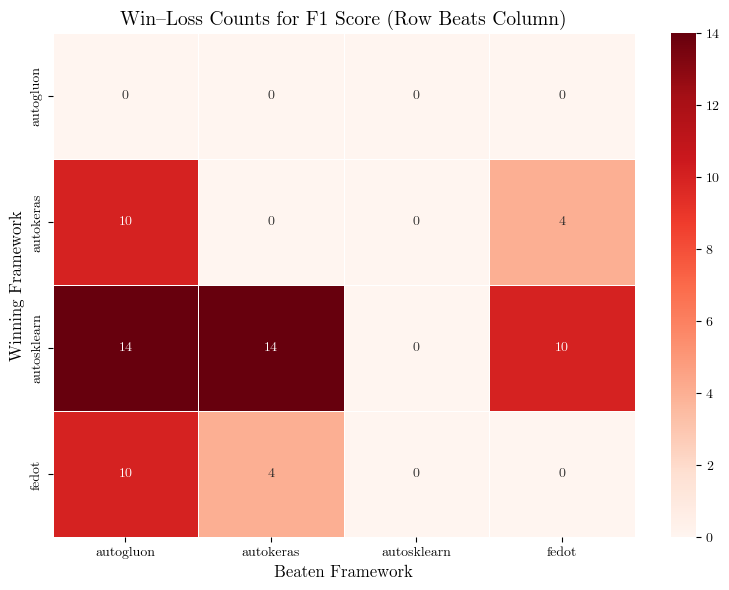

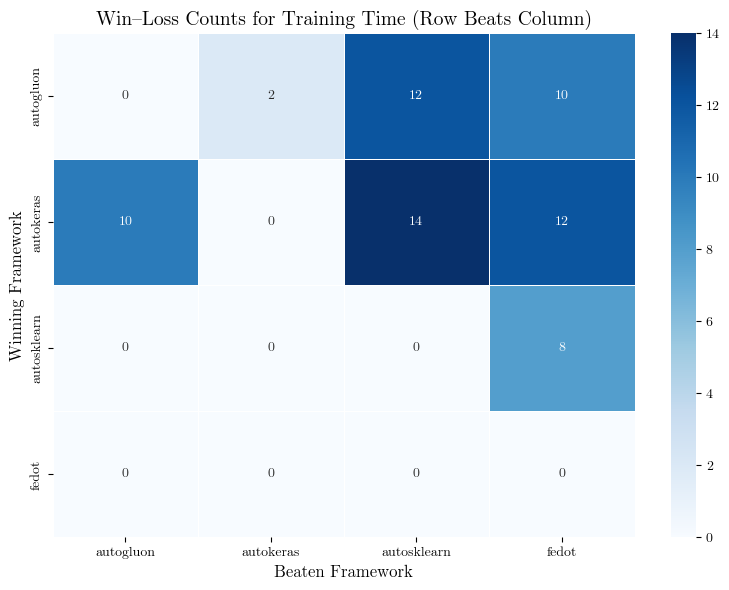

In [21]:
def aggregate_win_loss_matrices(df, posthocs, metric_col):
    """
    Builds a win-loss matrix for a given metric.

    Parameters:
    - df (pd.DataFrame): Original dataset.
    - posthocs (dict): Aggregated post-hoc test results.
    - metric_col (str): The metric to analyze ('f1' or 'training_time').

    Returns:
    - pd.DataFrame: Win-loss matrix for the given metric.
    """
    mean_metric_dict = create_mean_metric_dict(df, dataset_col='dataset', framework_col='framework', metric_col=metric_col)
    return build_win_loss_matrix(posthocs, mean_metric_dict, metric_col=metric_col)

def plot_win_loss_heatmap(df_wins, title, cmap, save_path):
    """
    Plots a heatmap for a given win-loss matrix.

    Parameters:
    - df_wins (pd.DataFrame): Win-loss matrix.
    - title (str): Title of the plot.
    - cmap (str): Color map for the heatmap.
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        df_wins,
        annot=True,
        cmap=cmap,
        fmt="d",
        linewidths=0.5
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Beaten Framework", fontsize=12)
    plt.ylabel("Winning Framework", fontsize=12)
    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Aggregate post-hoc test results
posthocs = aggregate_posthocs()

# Build win-loss matrices for F1 Score and Training Time
df_wins_f1 = aggregate_win_loss_matrices(df, posthocs, metric_col='f1')
df_wins_time = aggregate_win_loss_matrices(df, posthocs, metric_col='training_time')

# Plot heatmaps for both metrics
plot_win_loss_heatmap(df_wins_f1,
                      title="Win–Loss Counts for F1 Score (Row Beats Column)",
                      cmap="Reds",
                      save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_f1.png")

plot_win_loss_heatmap(df_wins_time,
                      title="Win–Loss Counts for Training Time (Row Beats Column)",
                      cmap="Blues",
                      save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_time.png")

C:\Users\marce\AppData\Local\Temp\ipykernel_36460\2722647950.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


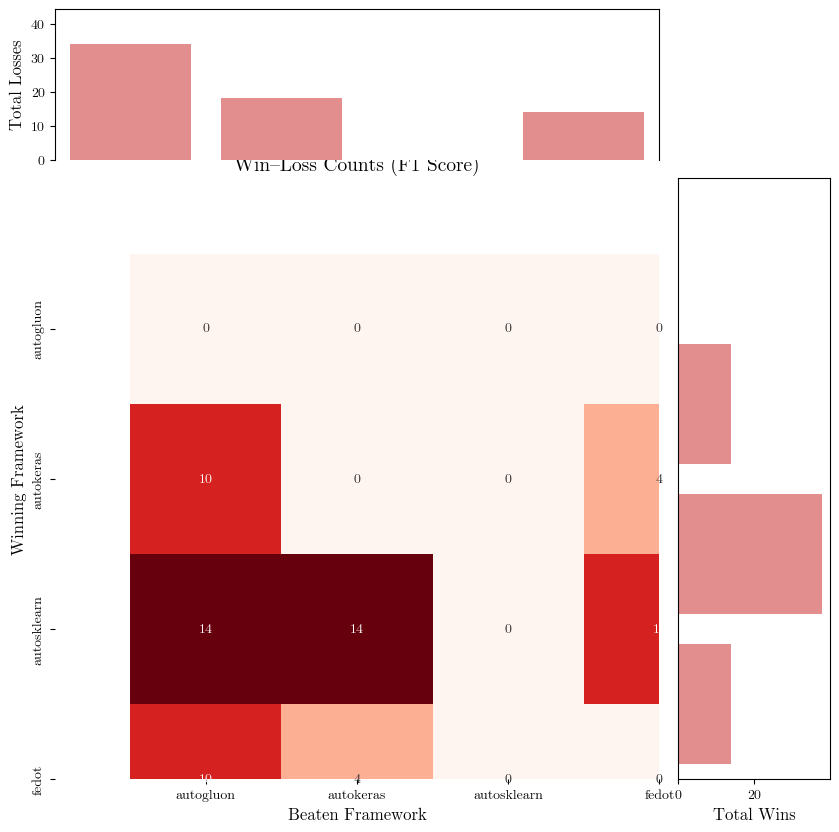

C:\Users\marce\AppData\Local\Temp\ipykernel_36460\2722647950.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


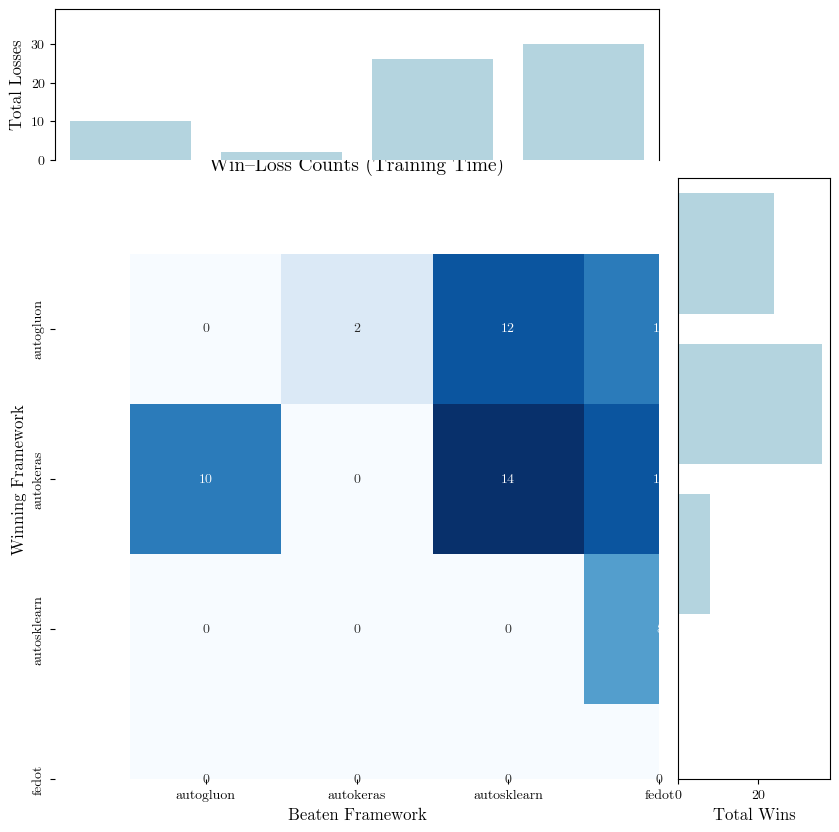

In [22]:
def plot_win_loss_heatmap_with_marginals(df_wins, save_path, title="Win–Loss Counts (Row beats Column)", cmap="Reds"):
    """
    Creates a heatmap of win-loss counts with marginal bar charts for total wins and total losses.

    Parameters:
    - df_wins (pd.DataFrame): F×F DataFrame where:
        - Rows = frameworks (winners)
        - Columns = frameworks (losers)
    - title (str): Title for the heatmap.
    - cmap (str): Color map for the heatmap.
    """
    # Compute total wins (row sums) and total losses (column sums)
    row_sums = df_wins.sum(axis=1)  # Total wins per framework
    col_sums = df_wins.sum(axis=0)  # Total times beaten

    fig = plt.figure(figsize=(10, 10))

    # Create a 2×2 GridSpec layout
    gs = fig.add_gridspec(
        2, 2,
        width_ratios=[4, 1],  # Main heatmap is wider; marginal bar is narrower
        height_ratios=[1, 4],  # Top bar is shorter; main heatmap is taller
        wspace=0.05, 
        hspace=0.05
    )

    # Define subplots
    ax_heatmap = fig.add_subplot(gs[1, 0])  # Main heatmap (bottom-left)
    ax_row_sum = fig.add_subplot(gs[1, 1], sharey=ax_heatmap)  # Row sums (bottom-right)
    ax_col_sum = fig.add_subplot(gs[0, 0], sharex=ax_heatmap)  # Column sums (top-left)

    # -------------------------------
    # 1) Main Heatmap
    # -------------------------------
    sns.heatmap(
        df_wins,
        annot=True,
        cmap=cmap,
        fmt="d",
        ax=ax_heatmap,
        cbar=False  # Hide colorbar to avoid clutter
    )
    ax_heatmap.set_title(title, fontsize=14)
    ax_heatmap.set_xlabel("Beaten Framework", fontsize=12)
    ax_heatmap.set_ylabel("Winning Framework", fontsize=12)

    # -------------------------------
    # 2) Bar chart of total wins (right side)
    # -------------------------------
    sns.barplot(
        x=row_sums.values, 
        y=row_sums.index, 
        orient='h',  # Horizontal bars
        ax=ax_row_sum,
        color='lightcoral' if cmap == "Reds" else 'lightblue'
    )
    ax_row_sum.set_ylabel("")
    ax_row_sum.set_xlabel("Total Wins", fontsize=12)
    ax_row_sum.yaxis.set_visible(False)  # Hide y-axis labels for clarity

    # -------------------------------
    # 3) Bar chart of total losses (top side)
    # -------------------------------
    sns.barplot(
        x=col_sums.index, 
        y=col_sums.values, 
        ax=ax_col_sum,
        color='lightcoral' if cmap == "Reds" else 'lightblue'
    )
    ax_col_sum.set_xlabel("")
    ax_col_sum.set_ylabel("Total Losses", fontsize=12)

    # Rotate x labels for readability
    plt.setp(ax_col_sum.get_xticklabels(), rotation=90)

    # Align top bar with heatmap's x-axis
    ax_col_sum.xaxis.set_visible(False)  # Hide x-axis line
    ax_col_sum.spines["bottom"].set_visible(False)
    ax_col_sum.margins(y=0.3)

    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_win_loss_heatmap_with_marginals(df_wins_f1,
                                     title="Win–Loss Counts (F1 Score)",
                                     cmap="Reds",
                                     save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_with_marginals_f1.png")

plot_win_loss_heatmap_with_marginals(df_wins_time,
                                     title="Win–Loss Counts (Training Time)",
                                     cmap="Blues",
                                     save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_heatmap_with_marginals_time.png")

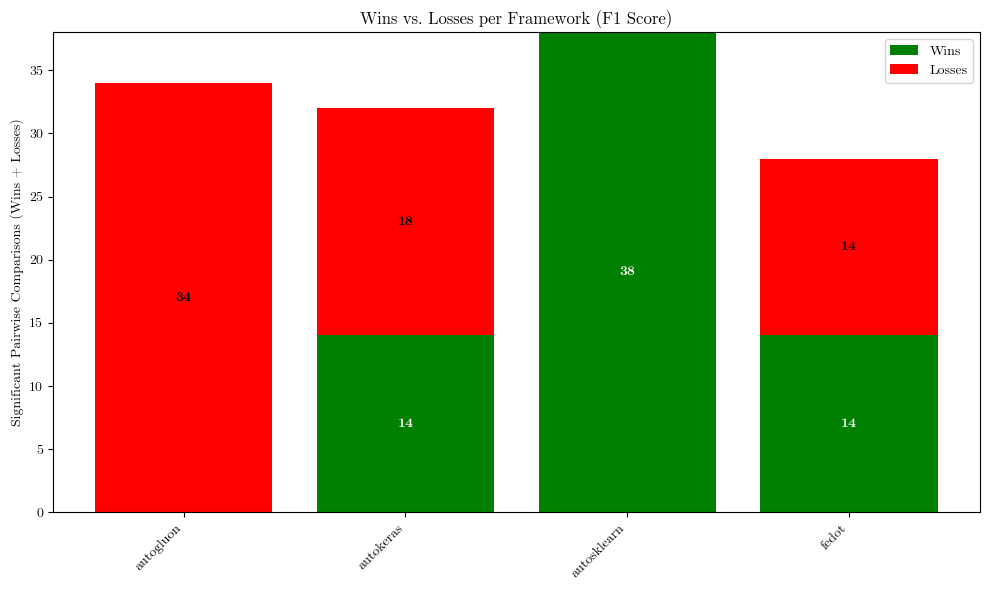

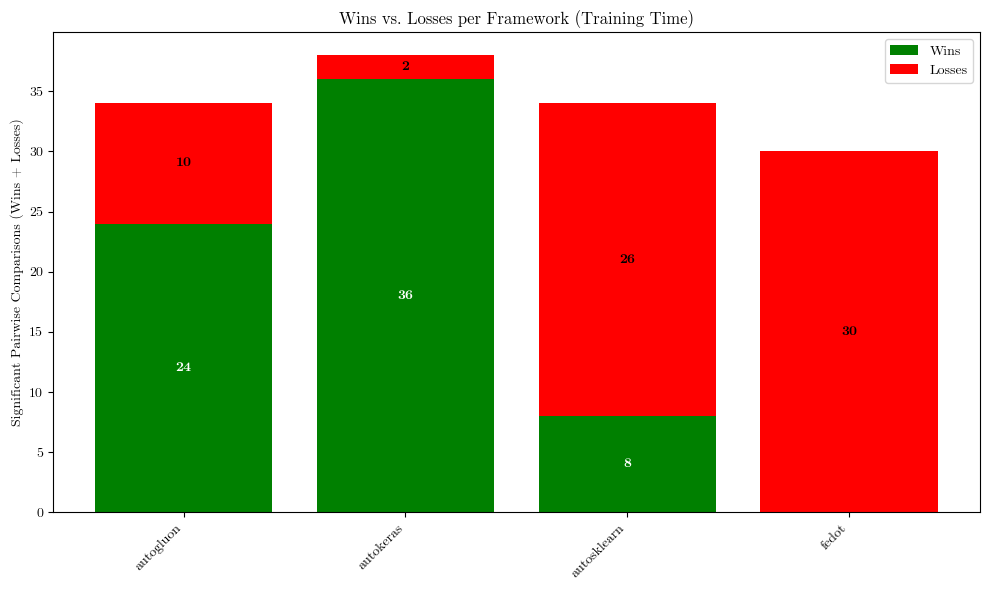

In [23]:
def plot_win_loss_bars(df_wins, save_path, title="Wins vs. Losses per Framework"):
    """
    Creates a stacked bar chart showing wins vs. losses per framework
    based on the significant post-hoc test results.

    Parameters:
    - df_wins (pd.DataFrame): F×F DataFrame where:
        - Rows = frameworks (winner)
        - Columns = frameworks (loser)
        - df_wins.loc[row_fw, col_fw] = # of datasets row_fw beats col_fw
    - title (str): Title for the plot.
    """
    # 1) Compute total wins and losses per framework
    row_sums = df_wins.sum(axis=1)  # Total wins per framework
    col_sums = df_wins.sum(axis=0)  # Total losses per framework

    frameworks = df_wins.index.tolist()
    wins = row_sums.values
    losses = col_sums.values

    # 2) Plot the stacked bars
    x = np.arange(len(frameworks))
    fig, ax = plt.subplots(figsize=(10, 6))

    bars_wins = ax.bar(
        x, wins, label="Wins", color="green"
    )

    bars_losses = ax.bar(
        x, losses, bottom=wins, label="Losses", color="red"
    )

    # 3) Annotate each bar with the corresponding win/loss count
    for i in range(len(frameworks)):
        w, l = wins[i], losses[i]
        
        if w > 0:
            ax.text(x[i], w / 2, str(int(w)), ha="center", va="center", color="white", fontweight="bold")
        
        if l > 0:
            ax.text(x[i], w + (l / 2), str(int(l)), ha="center", va="center", color="black", fontweight="bold")

    # 4) Cosmetic adjustments
    ax.set_xticks(x)
    ax.set_xticklabels(frameworks, rotation=45, ha="right")
    ax.set_ylabel("Significant Pairwise Comparisons (Wins + Losses)")
    ax.set_title(title)
    ax.legend()

    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_win_loss_bars(df_wins_f1,
                   title="Wins vs. Losses per Framework (F1 Score)",
                   save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_bars_f1.png")

plot_win_loss_bars(df_wins_time,
                   title="Wins vs. Losses per Framework (Training Time)",
                   save_path=f"stats/{scenario}/step_1_per_dataset_win_loss_bars_time.png")

In [24]:
import pandas as pd
import numpy as np

def convert_posthoc_to_long(posthocs):
    """
    Converts post-hoc test results into a long-form DataFrame, ensuring all frameworks appear in both columns.

    Parameters:
    - posthocs (list of dict): List containing post-hoc test results with datasets.

    Returns:
    - pd.DataFrame: Long-form DataFrame with pairwise comparisons.
    """
    posthoc_results_list = []

    # Get full list of all frameworks from all datasets
    all_frameworks = sorted(set(fw for entry in posthocs for fw in entry['posthoc_f1'].index).union(
                             set(fw for entry in posthocs for fw in entry['posthoc_f1'].columns),
                             set(fw for entry in posthocs for fw in entry['posthoc_training_time'].index),
                             set(fw for entry in posthocs for fw in entry['posthoc_training_time'].columns)))

    for entry in posthocs:
        dataset = entry['dataset']
        
        for metric, posthoc_df in [('F1 Score', entry['posthoc_f1']), ('Training Time', entry['posthoc_training_time'])]:
            # Ensure all frameworks are considered, even if missing from posthoc_df
            frameworks = all_frameworks  # Use full list, not just posthoc_df.index

            # Ensure the posthoc DataFrame includes all frameworks
            for fw in frameworks:
                if fw not in posthoc_df.index:
                    posthoc_df.loc[fw] = np.nan  # Add missing row
                if fw not in posthoc_df.columns:
                    posthoc_df[fw] = np.nan  # Add missing column

            for i, fw1 in enumerate(frameworks):
                for j, fw2 in enumerate(frameworks):
                    if i < j:  # Avoid duplicate pairs and diagonal
                        # Retrieve the p-value if it exists, otherwise assign NaN
                        p_value = posthoc_df.loc[fw1, fw2] if fw1 in posthoc_df.index and fw2 in posthoc_df.columns else float("nan")

                        # Randomize assignment to balance framework representation
                        if np.random.rand() > 0.5:  
                            fw1, fw2 = fw2, fw1  # Swap order randomly

                        posthoc_results_list.append({
                            "dataset": dataset,
                            "metric": metric,
                            "Framework A": fw1,
                            "Framework B": fw2,
                            "p-value": p_value
                        })

    return pd.DataFrame(posthoc_results_list)

# Call the function
df_posthoc = convert_posthoc_to_long(posthocs)

In [25]:
def fix_minus_sign(label):
    """Replace Unicode minus sign with a readable fallback."""
    return label.replace("−", r"$\mathdefault{-}$")  # Uses default TeX rendering for minus sign

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


    dataset    metric Framework A  Framework B       p-value
5       285  F1 Score       fedot  autosklearn  1.000000e+00
14    41464  F1 Score       fedot    autogluon           NaN
17    41464  F1 Score       fedot  autosklearn           NaN
28    41465  F1 Score       fedot    autokeras  0.000000e+00
29    41465  F1 Score       fedot  autosklearn  4.311761e-04
40    41468  F1 Score       fedot  autosklearn  3.167701e-06
52    41470  F1 Score       fedot    autokeras  4.876684e-01
62    41471  F1 Score       fedot    autogluon  7.389217e-03
65    41471  F1 Score       fedot  autosklearn  1.542769e-06
74    41473  F1 Score       fedot  autosklearn  2.317257e-12
76    41473  F1 Score       fedot  autosklearn  2.317257e-12


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


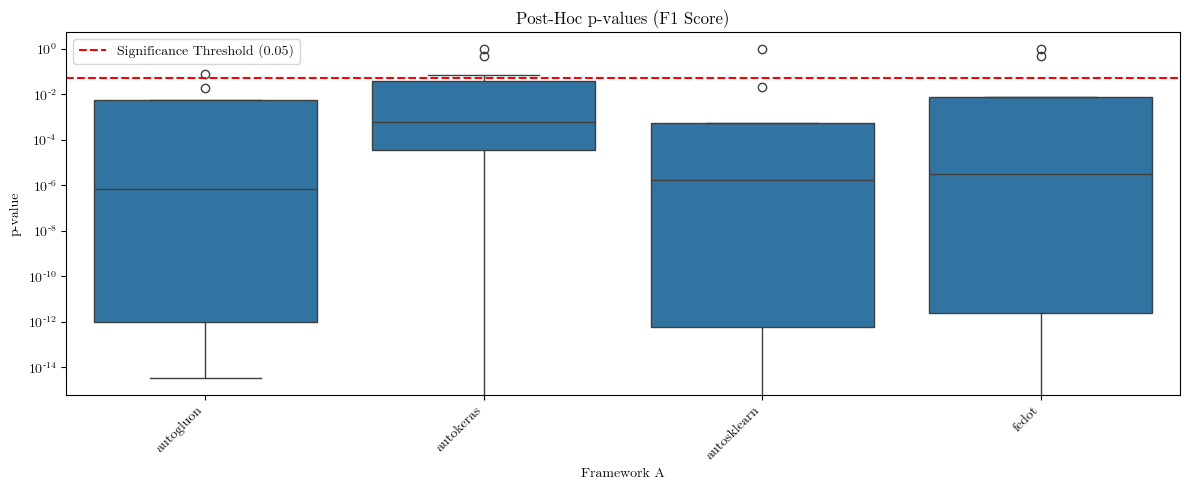

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


    dataset         metric Framework A  Framework B       p-value
8       285  Training Time       fedot  autosklearn  8.925271e-01
11      285  Training Time       fedot  autosklearn  8.925271e-01
23    41464  Training Time       fedot  autosklearn           NaN
32    41465  Training Time       fedot    autokeras  5.229346e-14
35    41465  Training Time       fedot  autosklearn  5.675945e-02
44    41468  Training Time       fedot    autokeras  3.725647e-10
70    41471  Training Time       fedot  autosklearn  1.571496e-02
71    41471  Training Time       fedot  autosklearn  1.571496e-02
82    41473  Training Time       fedot  autosklearn  1.381105e-04
83    41473  Training Time       fedot  autosklearn  1.381105e-04


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


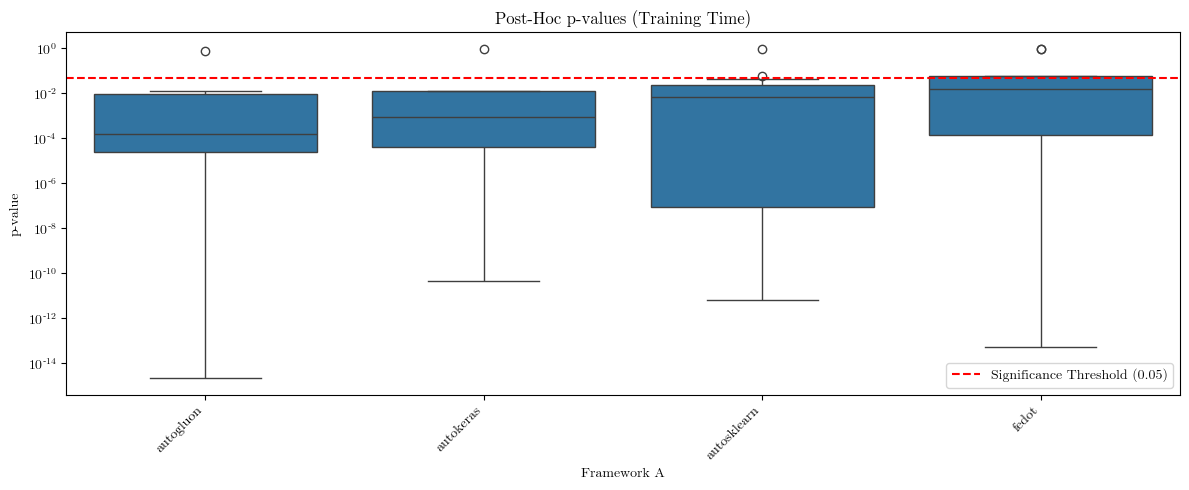

In [26]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_posthoc_pvalues(df_posthoc, metric, title, save_path):
    """
    Creates a boxplot for post-hoc p-values of a given metric, ensuring all frameworks appear.

    Parameters:
    - df_posthoc (pd.DataFrame): DataFrame containing post-hoc test results.
    - metric (str): The metric to analyze ('F1 Score' or 'Training Time').
    - title (str): Title for the plot.
    - save_path (str): Path to save the generated plot.
    """
    plt.figure(figsize=(12, 5))

    # Compute all frameworks from 'Framework A' and 'Framework B'
    all_frameworks = sorted(set(df_posthoc["Framework A"]).union(set(df_posthoc["Framework B"])))

    # Filter for the metric of interest
    df_filtered = df_posthoc[df_posthoc["metric"] == metric].copy()

    if df_filtered.empty:
        print(f"⚠️ No post-hoc results for {metric}. Skipping plot.")
        return

    # Ensure missing frameworks in 'Framework A' appear with NaN
    existing_frameworks_A = set(df_filtered["Framework A"])
    existing_frameworks_B = set(df_filtered["Framework B"])

    missing_frameworks_A = existing_frameworks_B - existing_frameworks_A  # Frameworks only in 'B'

    if missing_frameworks_A:
        print(f"⚠️ Fixing missing frameworks in 'Framework A': {missing_frameworks_A}")

        missing_rows = pd.DataFrame({
            "Framework A": list(missing_frameworks_A),
            "p-value": np.nan,
            "metric": metric
        })
        df_filtered = pd.concat([df_filtered, missing_rows], ignore_index=True)

    # Ensure `Framework A` includes frameworks that appear in `Framework B`
    frameworks_in_A = set(df_filtered["Framework A"])
    frameworks_in_B = set(df_filtered["Framework B"])

    missing_from_A = frameworks_in_B - frameworks_in_A  # Any framework that is only in "Framework B"
    if missing_from_A:
        print(f"⚠️ Fixing missing frameworks from 'Framework B' into 'Framework A': {missing_from_A}")
        for fw in missing_from_A:
            df_filtered = pd.concat([df_filtered, pd.DataFrame({
                "Framework A": [fw],
                "p-value": np.nan,
                "metric": metric
            })], ignore_index=True)

    # Check if `fedot` has valid p-values
    print(df_filtered[df_filtered["Framework A"] == "fedot"])

    # # Replace NaN p-values with 1.0 to make them visible but non-significant
    # df_filtered["p-value"].fillna(1.0, inplace=True)

    # Plot the p-values
    sns.boxplot(x="Framework A", y="p-value", data=df_filtered, order=all_frameworks)

    plt.axhline(y=alpha, color='r', linestyle='--', label=f'Significance Threshold ({alpha})')
    plt.title(title)
    plt.legend()

    # Improve x/y axis readability
    plt.yscale('log')
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Ensure save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_posthoc_pvalues(df_posthoc, metric="F1 Score", 
                     title="Post-Hoc p-values (F1 Score)", 
                     save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_box_f1.png")

plot_posthoc_pvalues(df_posthoc, metric="Training Time", 
                     title="Post-Hoc p-values (Training Time)", 
                     save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_box_time.png")

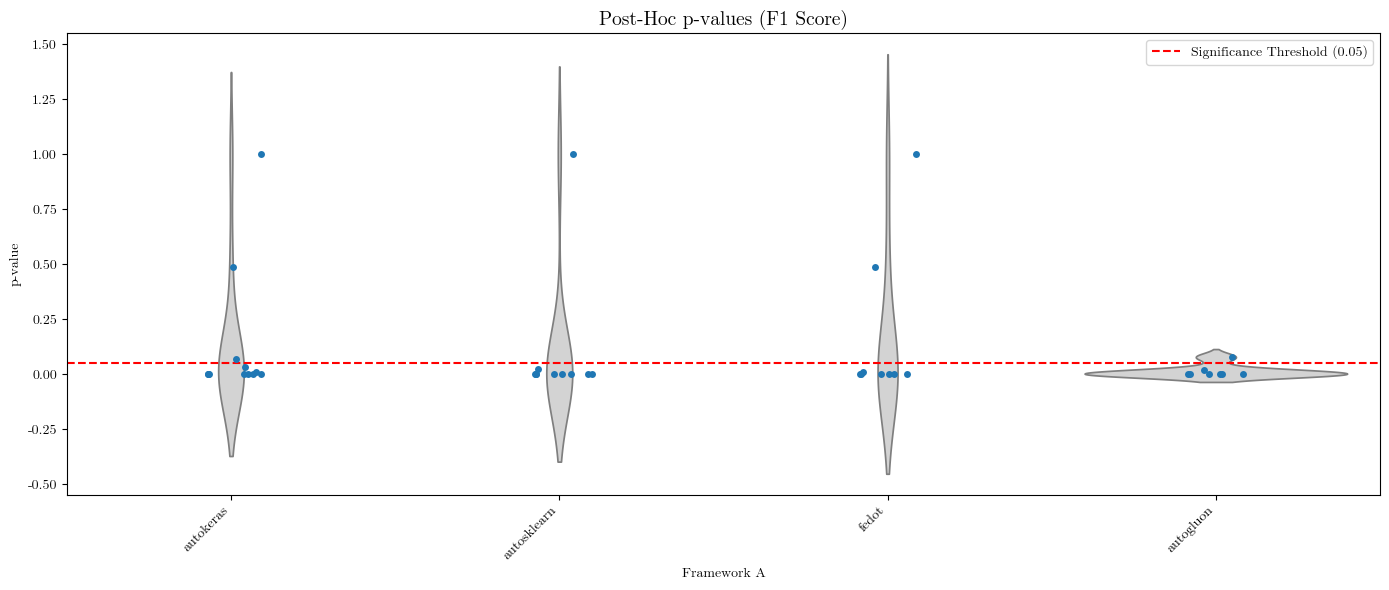

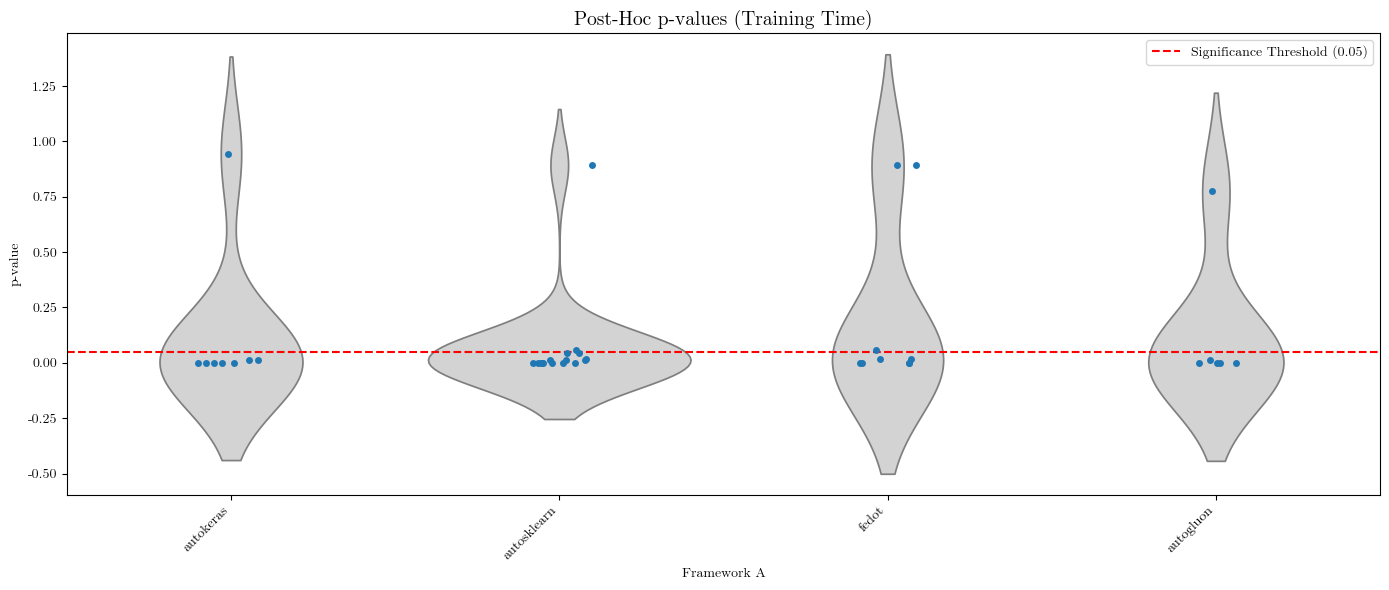

In [27]:
def plot_violin_strip_pvalues(df_posthoc, metric, title, save_path):
    """
    Creates a violin + strip plot for post-hoc p-values of a given metric.

    Parameters:
    - df_posthoc (pd.DataFrame): DataFrame containing post-hoc test results.
    - metric (str): The metric to analyze ('F1 Score' or 'Training Time').
    - title (str): Title for the plot.
    - save_path (str): Path to save the generated plot.
    """
    plt.figure(figsize=(14, 6))
    
    df_filtered = df_posthoc[df_posthoc["metric"] == metric]

    # Violin plot (distribution)
    sns.violinplot(x="Framework A", y="p-value", data=df_filtered, inner=None, color="lightgray")
    
    # Strip plot (individual data points)
    sns.stripplot(x="Framework A", y="p-value", data=df_filtered, jitter=True, dodge=True)
    
    # Significance threshold
    plt.axhline(y=alpha, color='r', linestyle='--', label=f'Significance Threshold ({alpha})')
    plt.title(title, fontsize=14)
    plt.ylabel("p-value")
    plt.legend()

    # Improve x-axis readability
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Ensure the save directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the plot
    plt.savefig(save_path, dpi=300)
    plt.show()

# Call the function for both F1 Score and Training Time
plot_violin_strip_pvalues(df_posthoc, metric="F1 Score", 
                          title="Post-Hoc p-values (F1 Score)", 
                          save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_violin_f1.png")

plot_violin_strip_pvalues(df_posthoc, metric="Training Time", 
                          title="Post-Hoc p-values (Training Time)", 
                          save_path=f"stats/{scenario}/step_1_per_dataset_post_hoc_violin_time.png")

## Extra

In [28]:
def extract_significant_comparisons(df_posthoc):
    """
    Extracts significant post-hoc comparisons for F1 Score and Training Time.

    Parameters:
    - df_posthoc (pd.DataFrame): Long-form DataFrame containing post-hoc test results.

    Returns:
    - pd.DataFrame: Summary of significant pairwise comparisons.
    """
    # Identify significant comparisons
    significant_f1 = df_posthoc[(df_posthoc["metric"] == "F1 Score") & (df_posthoc["p-value"] < alpha)]
    significant_time = df_posthoc[(df_posthoc["metric"] == "Training Time") & (df_posthoc["p-value"] < alpha)]

    # Rename dataset column for consistency
    significant_f1 = significant_f1.rename(columns={"dataset": "Dataset"})
    significant_time = significant_time.rename(columns={"dataset": "Dataset"})

    # Create a summary table for significant differences in F1 Score
    significance_summary = pd.DataFrame({
        "Dataset": significant_f1["Dataset"],
        "Framework A": significant_f1["Framework A"],
        "Framework B": significant_f1["Framework B"],
        "p-value (F1 Score)": significant_f1["p-value"]
    })

    # Merge with significant training time comparisons
    significant_time = significant_time.rename(columns={"p-value": "p-value (Training Time)"})
    significance_summary = significance_summary.merge(
        significant_time[["Dataset", "Framework A", "Framework B", "p-value (Training Time)"]],
        on=["Dataset", "Framework A", "Framework B"],
        how="left"
    )

    return significance_summary.dropna()  # Remove rows with no significant training time comparisons

# Call the function
significant_results = extract_significant_comparisons(df_posthoc)
significant_results

,Dataset,Framework A,Framework B,p-value (F1 Score),p-value (Training Time)
1,285,autosklearn,autokeras,2.497084e-07,6.248156e-12
2,285,autosklearn,autokeras,2.497084e-07,6.248156e-12
5,41464,autokeras,autosklearn,5.859585e-04,4.315705e-11
6,41465,autokeras,autogluon,0.000000e+00,1.299117e-02
7,41465,autosklearn,autokeras,0.000000e+00,2.434935e-08
9,41465,autokeras,autosklearn,0.000000e+00,2.434935e-08
10,41465,fedot,autokeras,0.000000e+00,5.229346e-14
15,41468,autosklearn,autokeras,2.174473e-02,5.180270e-05
17,41468,autosklearn,fedot,3.167701e-06,4.358288e-02
18,41468,autosklearn,fedot,3.167701e-06,4.358288e-02


In [29]:
def summarize_posthoc(df):
    summary = ""

    for dataset in df['dataset'].unique():
        dataset_results = df[df['dataset'] == dataset]
        
        summary += f"### Dataset {dataset} Analysis\n"
        
        for metric in dataset_results['metric'].unique():
            metric_results = dataset_results[dataset_results['metric'] == metric]
            significant_pairs = metric_results[metric_results['p-value'] < alpha]
            
            if significant_pairs.empty:
                summary += f"- No significant differences found for {metric}.\n"
            else:
                summary += f"- Significant differences for {metric}:\n"
                for _, row in significant_pairs.iterrows():
                    summary += f"  - {row['Framework A']} vs {row['Framework B']}: p = {row['p-value']:.3f}\n"
        
        summary += "\n"
    
    return summary

# Generate summary
posthoc_summary = summarize_posthoc(df_posthoc)
print(posthoc_summary)

### Dataset 285 Analysis
- Significant differences for F1 Score:
  - autokeras vs autosklearn: p = 0.000
  - autosklearn vs autokeras: p = 0.000
- Significant differences for Training Time:
  - autokeras vs autogluon: p = 0.002
  - autosklearn vs autokeras: p = 0.000
  - autosklearn vs autokeras: p = 0.000

### Dataset 41464 Analysis
- Significant differences for F1 Score:
  - autogluon vs autokeras: p = 0.001
  - autogluon vs autosklearn: p = 0.000
  - autokeras vs autosklearn: p = 0.001
- Significant differences for Training Time:
  - autokeras vs autogluon: p = 0.000
  - autosklearn vs autokeras: p = 0.000
  - autokeras vs autosklearn: p = 0.000

### Dataset 41465 Analysis
- Significant differences for F1 Score:
  - autokeras vs autogluon: p = 0.000
  - autosklearn vs autokeras: p = 0.000
  - autosklearn vs fedot: p = 0.000
  - autokeras vs autosklearn: p = 0.000
  - fedot vs autokeras: p = 0.000
  - fedot vs autosklearn: p = 0.000
- Significant differences for Training Time:
  - au